In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import yaml

In [2]:
from catboost import CatBoostRegressor, CatBoostClassifier
from catboost import Pool
from sklearn.model_selection import  train_test_split
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    precision_score,
    average_precision_score,
    recall_score,
    matthews_corrcoef,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
)
import shap
from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold

/root/anaconda3/envs/cp_amazy/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def score_regression_simple(target, predictions,) -> pd.DataFrame:
    '''
    Функция для подсчета метрик
    '''
    predictions = np.array(predictions)

    metrics = {
        "R2":       round(r2_score(target, predictions),3),
        "MAE":  round(mean_absolute_error(target, predictions),3),
        "MSE":  round(mean_squared_error(target, predictions),3),
        "RMSE":   round((np.sqrt(mean_squared_error(target, predictions))),3),
        "MAPE":        round(mean_absolute_percentage_error(target, predictions),3),
        } 
    return metrics


def score_classifier_simple(target, predictions, threshold=0.5) -> pd.DataFrame:
    '''
    Функция для подсчета метрик
    '''
    predictions = np.array(predictions)
    response = (predictions > threshold).astype(int)

    metrics = {
        "roc_auc_score":   round((np.sqrt(roc_auc_score(target, predictions))),3),
        "av_precision_score": round((np.sqrt(average_precision_score(target, predictions))),3),
        "accuracy_score":  round(accuracy_score(target, response),3),
        "precision_score":  round(precision_score(target, response),3),
        "recall_score":   round((np.sqrt(recall_score(target, response))),3),
        "f1_score":       round(f1_score(target, response),3),
        "matthews_corrcoef":        round(matthews_corrcoef(target, response),3),
        } 
    return metrics

In [4]:
def calc_min_price_rolling(data, delta_h=24, features=None):
    if features is None:
        features = ['rarity', 'genesis', 'sneaker_type', 'level', 'mint']

    result = np.zeros(len(data))

    for i in range(len(data)):
        #i = 156
        sample = data.iloc[i]
        data_tmp = data.iloc[:i]
        data_tmp = data_tmp[data_tmp['date'] > (sample['date'] - pd.Timedelta(delta_h, unit='h'))]

        for feature in features:
            data_tmp = data_tmp[(data_tmp[feature] == sample[feature])]
        result[i] = data_tmp['price'].min()
    
    return result

# SETUP

In [5]:
CONFIG_DIR = '../app/'

In [6]:
with open(f"{CONFIG_DIR}config_prod.yml", 'r') as ymlfile:
    config = yaml.load(ymlfile, Loader=yaml.SafeLoader)

In [7]:
BD_NAME = f'{config["DATASET"]}.csv'
BD_FOLDER = './data'
VERSION = config["VERSION"]
START_DATE = '2022-09-03'
TETS_DATE = '2022-09-29'

In [8]:
data_quality_expected_range_dict = {
    'sneaker':
        {
        #'is_type': {'genesis': bool},
        'is_in':
            {
            'rarity': ['common', 'uncommon', 'rare'],
            'sneaker_type': ['ranger', 'sprinter', 'hiker', 'coacher'],
            },
        'min_max':
            {
            'level': [0, 30],
            'base_performance': [0, 40],
            'base_fortune': [0, 40],
            'base_joy': [0, 40],
            'base_durability': [0, 40],
            'performance': [0, 500],
            'fortune': [0, 300],
            'joy': [0, 300],
            'durability': [0, 300],
            'mint': [0, 7],
            'buy_count_12H': [0, 500],
            'buy_count_24H': [0, 1000],
            'sell_count_24H': [0, 2000],
            'cancel_count_24H': [0, 1000],
            'token_all_activity_3H': [0, 30],
            'token_sell_activity_6H': [0, 30],
            },
        }
}

# DATA

In [9]:
data = pd.read_csv(f'{BD_FOLDER}/{BD_NAME}')
data

Columns (62,63,64,65,66,67) have mixed types. Specify dtype option on import or set low_memory=False.


,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,mrk_floor__rarity_type_genesis,mrk_floor__rarity_type,mrk_floor__all,mkr_count__rarity_type_genesis_lvl_mint,mrk_count__rarity_type_genesis_lvl,mrk_count__rarity_type_genesis,mrk_count__rarity_type,mrk_count__sneaker_all,mrk_count__box_all,mrk_count__all
0,1664992771,52170,39930,cancel,0x4eeec9917f0978d568e890eee27683769d03ba35,NaN,NaN,sneakers,common,ranger,...,0.55,0.55,0.55,10.0,11.0,318.0,509.0,562.0,98.0,660.0
1,1664992675,52077,49418,cancel,0x720963b0e3f02afafa78c50c8312854080c26c9b,NaN,NaN,sneakers,uncommon,hiker,...,1.89,1.89,0.55,8.0,13.0,43.0,51.0,562.0,98.0,660.0
2,1664992675,52408,57609,sell,0x64d90e3b7771b6ee24a829196ce805f802ca0f77,NaN,0.65,sneakers,common,sprinter,...,0.55,0.55,0.55,143.0,188.0,317.0,508.0,562.0,98.0,660.0
3,1664992660,52361,57609,cancel,0x64d90e3b7771b6ee24a829196ce805f802ca0f77,NaN,NaN,sneakers,common,sprinter,...,0.55,0.55,0.55,144.0,189.0,318.0,509.0,563.0,98.0,661.0
4,1664992639,52074,47741,cancel,0x720963b0e3f02afafa78c50c8312854080c26c9b,NaN,NaN,sneakers,uncommon,ranger,...,1.89,1.89,0.55,18.0,18.0,44.0,52.0,564.0,98.0,662.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76980,1661029606,13798,24335,sell,0x0d4eafe1ed97f590fde02c21dcf2b0ae6cb106d7,NaN,0.90,sneakers,common,hiker,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76981,1661029594,13797,27211,sell,0xb83b40609684191abba9184f627a112df5ac0a44,NaN,0.92,sneakers,common,hiker,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76982,1661029585,13596,32513,buy,0x1041f11e1738c5ea8d3ff3c5a1a314a617313ee1,0x2eeedd73169a17e4f79a6d6bea238f11b05238e4,0.92,box,common,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76983,1661029462,13796,32779,sell,0x668ff3191878ed0f7112031305eccb1d79a865e4,NaN,1.00,sneakers,common,sprinter,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
data.columns

Index(['timestamp', 'mrk_id', 'token_id', 'event', 'wallet_from', 'wallet_to',
       'price', 'item_type', 'rarity', 'sneaker_type', 'level',
       'base_performance', 'base_fortune', 'base_joy', 'base_durability',
       'performance', 'fortune', 'joy', 'durability', 'mint', 'parent1',
       'parent2', 'genesis', 'parent1_sneaker_type', 'parent2_sneaker_type',
       'price_bnb', 'price_azy', 'price_amt', 'wallet_from_buy_count',
       'wallet_from_all_count', 'token_all_activity_3H',
       'token_sell_activity_6H', 'buy_count_12H', 'buy_count_24H',
       'buy_count_48H', 'sell_count_12H', 'sell_count_24H', 'sell_count_48H',
       'cancel_count_12H', 'cancel_count_24H', 'cancel_count_48H',
       'min_price_all_24H', 'min_price_by_rarity_genesis_type_level_mint_24H',
       'min_price_by_rarity_genesis_type_level_mint_48H',
       'min_price_by_rarity_genesis_type_level_mint_72H',
       'min_price_by_rarity_genesis_type_24H',
       'min_price_by_rarity_genesis_type_48H',
    

In [11]:
data[['wallet_first_sneaker_time',
       'time_ownership', 'wallet_box_mint', 'wallet_sneaker_mint',
       'time_level_up', 'time_level_up_for_mint', 'base_mint_price_amt',
       'base_mint_price_azy', 'base_mint_price_bnb']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76985 entries, 0 to 76984
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   wallet_first_sneaker_time  44295 non-null  float64
 1   time_ownership             44295 non-null  float64
 2   wallet_box_mint            44295 non-null  float64
 3   wallet_sneaker_mint        44295 non-null  float64
 4   time_level_up              49264 non-null  float64
 5   time_level_up_for_mint     53197 non-null  float64
 6   base_mint_price_amt        53197 non-null  float64
 7   base_mint_price_azy        53197 non-null  float64
 8   base_mint_price_bnb        43174 non-null  float64
dtypes: float64(9)
memory usage: 5.3 MB


In [12]:
data.genesis

0        False
1        False
2        False
3        False
4        False
         ...  
76980     True
76981    False
76982    False
76983    False
76984     True
Name: genesis, Length: 76985, dtype: bool

In [13]:
data = data[(data.item_type == 'sneakers') & (data.event == 'buy')].copy()
data

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,mrk_floor__rarity_type_genesis,mrk_floor__rarity_type,mrk_floor__all,mkr_count__rarity_type_genesis_lvl_mint,mrk_count__rarity_type_genesis_lvl,mrk_count__rarity_type_genesis,mrk_count__rarity_type,mrk_count__sneaker_all,mrk_count__box_all,mrk_count__all
16,1664992315,50855,60565,buy,0xb03ef39784640c2a7014fcec8697998953c02d04,0xd9a2b07edbbbf1e3f25106ed84bc82e77cab243e,0.61,sneakers,common,ranger,...,0.55,0.55,0.55,146.0,191.0,320.0,514.0,574.0,98.0,672.0
21,1664992207,51502,28433,buy,0xeeab85f8b9497c14de336917a8f1d17b0314d60f,0x00234055bb4dd241729bbc5f4a59dddfcf43140b,0.65,sneakers,common,hiker,...,0.62,0.55,0.55,87.0,98.0,197.0,517.0,577.0,98.0,675.0
24,1664992117,51901,24899,buy,0x37211560d9fa9f802ea152254395f03aff4f2a37,0x00234055bb4dd241729bbc5f4a59dddfcf43140b,0.65,sneakers,common,hiker,...,0.62,0.55,0.55,87.0,98.0,197.0,516.0,576.0,99.0,675.0
28,1664992003,52402,60796,buy,0x0d0f18a1c24ff2209b1ccf95eedda78f337f8694,0x1bb4263f60e09f368feefa779588d4aaf530fe42,0.55,sneakers,common,hiker,...,0.55,0.55,0.55,147.0,191.0,319.0,518.0,579.0,99.0,678.0
53,1664991450,52393,48145,buy,0xee1abb84fbe1dcaf058ef38d62de5c36c0e0a201,0x7201fa9c469fcb69e5a1c4ad3b68005946eba0c8,0.57,sneakers,common,ranger,...,0.56,0.56,0.56,145.0,189.0,320.0,522.0,586.0,99.0,685.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76922,1661037238,13786,18163,buy,0x53d77d21ebf48461514dc4399f53e1dd4fd36067,0x4bba52eabf7c05c20f0406411f2107832ccdda0f,0.97,sneakers,common,coacher,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76945,1661035060,13801,17327,buy,0x5357ef225250a79fed6de8e925d2ad4fc88d461f,0x7417ce741427022821a39d691e6a2613ff48f17a,1.10,sneakers,common,ranger,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76959,1661032615,13731,27159,buy,0x80cf6cf64b8fa2cd302d6c190182ee8589ce10ae,0x1452911e6f252ab94809266a3934dfd89c77b708,1.25,sneakers,common,hiker,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76964,1661031799,13694,20002,buy,0x7417ce741427022821a39d691e6a2613ff48f17a,0x136f85ed70bbd9476c9175388e79e2456b8e043e,1.30,sneakers,common,ranger,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# data_quality

In [14]:
dq = data_quality_expected_range_dict['sneaker']['is_in']
for feature in dq.keys():
    if data[feature].isna().sum() > 0:
        print(f'Nans in {feature}')

    for element in data[feature].unique():
        if element not in dq[feature]:
            print(f'{feature} not in data_quality_expected_range_dict. get {element}')

dq = data_quality_expected_range_dict['sneaker']['min_max']
for feature in dq.keys():
    if data[feature].isna().sum() > 0:
        print(f'Nans in {feature}')

    if data[feature].min() < dq[feature][0]:
        print(f'{feature} less then expected. get: {data[feature].max()} | expected: {dq[feature][1]}')

    if data[feature].max() > dq[feature][1]:
        print(f'{feature} more then expected. get: {data[feature].max()} | expected: {dq[feature][1]}')

buy_count_12H more then expected. get: 567.0 | expected: 500
sell_count_24H more then expected. get: 2156 | expected: 2000
cancel_count_24H more then expected. get: 1769 | expected: 1000


In [15]:
data['mint'].isna().sum()

0

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13346 entries, 16 to 76978
Data columns (total 81 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   timestamp                                        13346 non-null  int64  
 1   mrk_id                                           13346 non-null  int64  
 2   token_id                                         13346 non-null  int64  
 3   event                                            13346 non-null  object 
 4   wallet_from                                      13308 non-null  object 
 5   wallet_to                                        13346 non-null  object 
 6   price                                            13346 non-null  float64
 7   item_type                                        13346 non-null  object 
 8   rarity                                           13346 non-null  object 
 9   sneaker_type               

In [17]:
data[['wallet_first_sneaker_time',
       'time_ownership', 'wallet_box_mint', 'wallet_sneaker_mint',
       'time_level_up', 'time_level_up_for_mint', 'base_mint_price_amt',
       'base_mint_price_azy', 'base_mint_price_bnb']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13346 entries, 16 to 76978
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   wallet_first_sneaker_time  13346 non-null  float64
 1   time_ownership             13346 non-null  float64
 2   wallet_box_mint            13346 non-null  float64
 3   wallet_sneaker_mint        13346 non-null  float64
 4   time_level_up              13346 non-null  float64
 5   time_level_up_for_mint     13346 non-null  float64
 6   base_mint_price_amt        13346 non-null  float64
 7   base_mint_price_azy        13346 non-null  float64
 8   base_mint_price_bnb        10956 non-null  float64
dtypes: float64(9)
memory usage: 1.0 MB


In [18]:
data[['wallet_first_sneaker_time',
       'time_ownership', 'wallet_box_mint', 'wallet_sneaker_mint',
       'time_level_up', 'time_level_up_for_mint', 'base_mint_price_amt',
       'base_mint_price_azy', 'base_mint_price_bnb']]

,wallet_first_sneaker_time,time_ownership,wallet_box_mint,wallet_sneaker_mint,time_level_up,time_level_up_for_mint,base_mint_price_amt,base_mint_price_azy,base_mint_price_bnb
16,1.659603e+09,787590.0,8.0,8.0,900.0,1800.0,300.0,200.0,0.421792
21,1.657812e+09,56101.0,7.0,7.0,900.0,1800.0,300.0,200.0,0.421792
24,1.657815e+09,31819.0,6.0,6.0,900.0,1800.0,300.0,200.0,0.421792
28,1.659601e+09,776561.0,18.0,12.0,900.0,1800.0,300.0,200.0,0.420795
53,1.657800e+09,1935212.0,14.0,14.0,900.0,1800.0,300.0,200.0,0.420635
...,...,...,...,...,...,...,...,...,...
76922,1.657803e+09,18915.0,5.0,0.0,900.0,1800.0,300.0,200.0,NaN
76945,1.657800e+09,5178.0,6.0,10.0,900.0,1800.0,300.0,200.0,NaN
76959,1.657800e+09,446391.0,5.0,7.0,900.0,1800.0,300.0,200.0,NaN
76964,1.659970e+09,1062034.0,0.0,1.0,2700.0,1800.0,300.0,200.0,NaN


In [19]:
data.columns

Index(['timestamp', 'mrk_id', 'token_id', 'event', 'wallet_from', 'wallet_to',
       'price', 'item_type', 'rarity', 'sneaker_type', 'level',
       'base_performance', 'base_fortune', 'base_joy', 'base_durability',
       'performance', 'fortune', 'joy', 'durability', 'mint', 'parent1',
       'parent2', 'genesis', 'parent1_sneaker_type', 'parent2_sneaker_type',
       'price_bnb', 'price_azy', 'price_amt', 'wallet_from_buy_count',
       'wallet_from_all_count', 'token_all_activity_3H',
       'token_sell_activity_6H', 'buy_count_12H', 'buy_count_24H',
       'buy_count_48H', 'sell_count_12H', 'sell_count_24H', 'sell_count_48H',
       'cancel_count_12H', 'cancel_count_24H', 'cancel_count_48H',
       'min_price_all_24H', 'min_price_by_rarity_genesis_type_level_mint_24H',
       'min_price_by_rarity_genesis_type_level_mint_48H',
       'min_price_by_rarity_genesis_type_level_mint_72H',
       'min_price_by_rarity_genesis_type_24H',
       'min_price_by_rarity_genesis_type_48H',
    

In [20]:
#int_columns = ['timestamp', 'mrk_id', 'token_id', 'level', 'mint']
#float_columns = ['performance', 'fortune', 'joy', 'durability', 'price']
#cat_columns = ['item_type', 'rarity', 'sneaker_type',]

In [21]:
#for columns in int_columns:
#    data[columns] = data[columns].astype('int')

# for columns in float_columns:
#     data[columns] = data[columns].astype('float')

#for columns in cat_columns:
#    data[columns] = data[columns].astype('category')

In [22]:
#data['min_price_by_rarity_genesis_type_level_mint_24H'] = data['min_price_by_rarity_genesis_type_level_mint_24H'].fillna(0)
#data['min_price_by_rarity_genesis_type_24H'] = data['min_price_by_rarity_genesis_type_24H'].fillna(0)

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13346 entries, 16 to 76978
Data columns (total 81 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   timestamp                                        13346 non-null  int64  
 1   mrk_id                                           13346 non-null  int64  
 2   token_id                                         13346 non-null  int64  
 3   event                                            13346 non-null  object 
 4   wallet_from                                      13308 non-null  object 
 5   wallet_to                                        13346 non-null  object 
 6   price                                            13346 non-null  float64
 7   item_type                                        13346 non-null  object 
 8   rarity                                           13346 non-null  object 
 9   sneaker_type               

In [24]:
data

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,mrk_floor__rarity_type_genesis,mrk_floor__rarity_type,mrk_floor__all,mkr_count__rarity_type_genesis_lvl_mint,mrk_count__rarity_type_genesis_lvl,mrk_count__rarity_type_genesis,mrk_count__rarity_type,mrk_count__sneaker_all,mrk_count__box_all,mrk_count__all
16,1664992315,50855,60565,buy,0xb03ef39784640c2a7014fcec8697998953c02d04,0xd9a2b07edbbbf1e3f25106ed84bc82e77cab243e,0.61,sneakers,common,ranger,...,0.55,0.55,0.55,146.0,191.0,320.0,514.0,574.0,98.0,672.0
21,1664992207,51502,28433,buy,0xeeab85f8b9497c14de336917a8f1d17b0314d60f,0x00234055bb4dd241729bbc5f4a59dddfcf43140b,0.65,sneakers,common,hiker,...,0.62,0.55,0.55,87.0,98.0,197.0,517.0,577.0,98.0,675.0
24,1664992117,51901,24899,buy,0x37211560d9fa9f802ea152254395f03aff4f2a37,0x00234055bb4dd241729bbc5f4a59dddfcf43140b,0.65,sneakers,common,hiker,...,0.62,0.55,0.55,87.0,98.0,197.0,516.0,576.0,99.0,675.0
28,1664992003,52402,60796,buy,0x0d0f18a1c24ff2209b1ccf95eedda78f337f8694,0x1bb4263f60e09f368feefa779588d4aaf530fe42,0.55,sneakers,common,hiker,...,0.55,0.55,0.55,147.0,191.0,319.0,518.0,579.0,99.0,678.0
53,1664991450,52393,48145,buy,0xee1abb84fbe1dcaf058ef38d62de5c36c0e0a201,0x7201fa9c469fcb69e5a1c4ad3b68005946eba0c8,0.57,sneakers,common,ranger,...,0.56,0.56,0.56,145.0,189.0,320.0,522.0,586.0,99.0,685.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76922,1661037238,13786,18163,buy,0x53d77d21ebf48461514dc4399f53e1dd4fd36067,0x4bba52eabf7c05c20f0406411f2107832ccdda0f,0.97,sneakers,common,coacher,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76945,1661035060,13801,17327,buy,0x5357ef225250a79fed6de8e925d2ad4fc88d461f,0x7417ce741427022821a39d691e6a2613ff48f17a,1.10,sneakers,common,ranger,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76959,1661032615,13731,27159,buy,0x80cf6cf64b8fa2cd302d6c190182ee8589ce10ae,0x1452911e6f252ab94809266a3934dfd89c77b708,1.25,sneakers,common,hiker,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76964,1661031799,13694,20002,buy,0x7417ce741427022821a39d691e6a2613ff48f17a,0x136f85ed70bbd9476c9175388e79e2456b8e043e,1.30,sneakers,common,ranger,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
data['date'] = pd.to_datetime(data['timestamp'], unit='s')
data = data.sort_values('date')

In [26]:
data[data.duplicated(['token_id', 'item_type', 'rarity', 'sneaker_type', 'level', 'mint',])]

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,mrk_floor__rarity_type,mrk_floor__all,mkr_count__rarity_type_genesis_lvl_mint,mrk_count__rarity_type_genesis_lvl,mrk_count__rarity_type_genesis,mrk_count__rarity_type,mrk_count__sneaker_all,mrk_count__box_all,mrk_count__all,date
76489,1661076949,14027,23846,buy,0x888f37fa33e5ed1a91e7b288cab38f051588ae2a,0x7bdf18948f2b640ba7fea97875849038bd43da2c,0.73,sneakers,common,sprinter,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-08-21 10:15:49
76438,1661079343,14070,20408,buy,0x888f37fa33e5ed1a91e7b288cab38f051588ae2a,0x7dd69ca014565e2c9e1b47beabf57a4469d51fe1,0.73,sneakers,common,sprinter,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-08-21 10:55:43
76235,1661087557,14094,26385,buy,0xa068379c563f7db21cc9c378a0f2a92ee64af7ed,0x06333746416b07371d84d1f862a352ec7ca1ab10,1.16,sneakers,common,hiker,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-08-21 13:12:37
76040,1661095945,14208,16352,buy,0xec04f1a68a3618028f3431ccf570508d95d34dce,0x3ae4020278e724bec4d24135bf9d42b6879a648f,0.69,sneakers,common,sprinter,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-08-21 15:32:25
75309,1661155769,14662,31425,buy,0x2b2f9ed8123c058c6f69cac2ab603ee5cb46d50c,0xf1a560df54f04b45e756d1cb36241fec633134a2,0.70,sneakers,common,sprinter,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-08-22 08:09:29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,1664982945,52312,38503,buy,0x3041e1e30f13fe2ffee1c0d970be06a84de6a47b,0x8456ff36f859fe539c4b89092c98a5a2c82e619b,0.50,sneakers,common,ranger,...,0.00,0.00,168.0,215.0,347.0,568.0,633.0,99.0,732.0,2022-10-05 15:15:45
259,1664983017,52260,31195,buy,0x3041e1e30f13fe2ffee1c0d970be06a84de6a47b,0x3b11102a4d5a805ce5f896203ec5ee758f6d4947,0.50,sneakers,common,sprinter,...,0.00,0.00,167.0,214.0,346.0,567.0,632.0,99.0,731.0,2022-10-05 15:16:57
249,1664983384,52267,49577,buy,0x1243a0994bfe1a284eff11d8868b0f4b7d36648b,0xe07c8b4e4a56ee119d4a4e329b5ccff2dd51c3d6,0.51,sneakers,common,sprinter,...,0.00,0.00,163.0,209.0,342.0,561.0,625.0,99.0,724.0,2022-10-05 15:23:04
145,1664987287,52357,25036,buy,0x3fc589e36bf29323519f49a37dad4219b2334071,0xd1c26da45a9cb578a4511d9bdae8b34e5cf29cd2,1.40,sneakers,common,hiker,...,0.52,0.52,8.0,20.0,205.0,540.0,604.0,98.0,702.0,2022-10-05 16:28:07


In [27]:
#len(data[(data.date >= START_DATE) & (data.date <= TETS_DATE)])

In [28]:
#train_data = data[(data.date >= START_DATE) & (data.date <= TETS_DATE)].copy()

# ML

## FE

In [29]:
#data['min_price_by_rarity_genesis_type_level_mint_24H_nan'] = data['min_price_by_rarity_genesis_type_level_mint_24H'].isna()
#data['min_price_by_rarity_genesis_type_24H_nan'] = data['min_price_by_rarity_genesis_type_24H'].isna()

#data['min_price_by_rarity_genesis_type_level_mint_24H'] = data['min_price_by_rarity_genesis_type_level_mint_24H'].fillna(0)
#data['min_price_by_rarity_genesis_type_24H'] = data['min_price_by_rarity_genesis_type_24H'].fillna(0)

data['sum_activity_24H'] = data['buy_count_24H'] + data['sell_count_24H'] + data['cancel_count_24H']
data['sells_activity_24H'] = data['sell_count_24H'] / data['buy_count_24H']

In [30]:
data['token_sell_activity_6H'].max()

11.0

In [31]:
data['min_price_by_rarity_genesis_type_level_mint_24H'] = data['min_price_by_rarity_genesis_type_level_mint_24H'].fillna(np.nan)
data['min_price_by_rarity_genesis_type_24H'] = data['min_price_by_rarity_genesis_type_24H'].fillna(np.nan)

In [32]:
# Перекуп датасет

dupl_df = data[data.duplicated(['token_id', 'item_type', 'rarity', 'sneaker_type', 'level', 'mint',], keep=False)]

In [33]:
data[data['token_id'] == 34874]

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,mkr_count__rarity_type_genesis_lvl_mint,mrk_count__rarity_type_genesis_lvl,mrk_count__rarity_type_genesis,mrk_count__rarity_type,mrk_count__sneaker_all,mrk_count__box_all,mrk_count__all,date,sum_activity_24H,sells_activity_24H
61825,1662138884,21406,34874,buy,0x92ede55a13c314bc7ca513734240d5d751b73008,0xa9343304ac2e9e45c0470e1ece4ca37c9774ce51,1.07,sneakers,common,coacher,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-09-02 17:14:44,1654,1.869180
57587,1662430561,23510,34874,buy,0xa9343304ac2e9e45c0470e1ece4ca37c9774ce51,0x3273af210822c44afd7254510e612e4dbb1040a7,0.97,sneakers,common,coacher,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-09-06 02:16:01,1079,2.341772


In [34]:
len(dupl_df)

3523

In [35]:
count_list = []
final_df = pd.DataFrame()

for token_id in dupl_df['token_id'].unique():
    data_tmp = dupl_df[dupl_df['token_id'] == token_id]
    #if data_tmp.iloc[0]['wallet_to'] == data_tmp.iloc[1]['wallet_from']:
    #print(len(data_tmp))
    i=0
    #for i in range(len(data_tmp)-1):
        #print(i)
    sample = data_tmp.iloc[i].copy()
    sample['sell_wallet_from'] = data_tmp.iloc[i+1]['wallet_from']
    sample['sell_price'] = data_tmp.iloc[i+1]['price']
    sample['sell_data'] = data_tmp.iloc[i+1]['date']
    sample['profit'] = (data_tmp.iloc[i+1]['price'] - ((data_tmp.iloc[i+1]['price']/100) * 5)) - data_tmp.iloc[i]['price']
    final_df = pd.concat([final_df, sample], ignore_index=True, sort=False, axis=1)
    
    #break

In [36]:
final_df = final_df.T
final_df

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,mrk_count__sneaker_all,mrk_count__box_all,mrk_count__all,date,sum_activity_24H,sells_activity_24H,sell_wallet_from,sell_price,sell_data,profit
0,1661065858,13953,31752,buy,0x8109ddb2277068a597cc9511e94f288b4f72e36c,0x5357ef225250a79fed6de8e925d2ad4fc88d461f,0.76,sneakers,common,sprinter,...,NaN,NaN,NaN,2022-08-21 07:10:58,911,4.683168,0x5357ef225250a79fed6de8e925d2ad4fc88d461f,0.9,2022-09-02 20:03:07,0.095
1,1661069971,13988,23846,buy,0xa080c839f04044eef1574e234ab5b0063d2e01c1,0xf3df1c64cb2e66400ef968caabfbe665457d25d4,0.5,sneakers,common,sprinter,...,NaN,NaN,NaN,2022-08-21 08:19:31,908,4.256881,0x888f37fa33e5ed1a91e7b288cab38f051588ae2a,0.73,2022-08-21 10:15:49,0.1935
2,1661070010,13991,20408,buy,0xa080c839f04044eef1574e234ab5b0063d2e01c1,0xf3df1c64cb2e66400ef968caabfbe665457d25d4,0.5,sneakers,common,sprinter,...,NaN,NaN,NaN,2022-08-21 08:20:10,910,4.227273,0x888f37fa33e5ed1a91e7b288cab38f051588ae2a,0.73,2022-08-21 10:55:43,0.1935
3,1661079088,14089,26385,buy,0x25ad8afeb7b5c119fdbabb2ec99f84a611caea2a,0xa068379c563f7db21cc9c378a0f2a92ee64af7ed,0.8,sneakers,common,hiker,...,NaN,NaN,NaN,2022-08-21 10:51:28,978,4.469027,0xa068379c563f7db21cc9c378a0f2a92ee64af7ed,1.16,2022-08-21 13:12:37,0.302
4,1661082994,14081,26390,buy,0x627afb1341cb1ae3cb3546424709dba42d88bde9,0xd96fcc51a852767af7a599a5bdf2daf0f162627b,0.72,sneakers,common,sprinter,...,NaN,NaN,NaN,2022-08-21 11:56:34,998,4.557522,0xd96fcc51a852767af7a599a5bdf2daf0f162627b,0.7,2022-08-29 16:25:54,-0.055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1589,1664906772,50874,63153,buy,0xe5216a7d3c43e76a312b983070c1cbdfd0a98c7c,0xae9dbe3feb9fd03945ed79f79142e8787fe47907,0.59,sneakers,common,ranger,...,622.0,105.0,727.0,2022-10-04 18:06:12,2905,4.856698,0xae9dbe3feb9fd03945ed79f79142e8787fe47907,0.67,2022-10-05 11:28:36,0.0465
1590,1664946961,51657,59040,buy,0x9f12933b69de9015b3ce11e7ab98cd4b3a6a5476,0x2b2f9ed8123c058c6f69cac2ab603ee5cb46d50c,0.5,sneakers,common,hiker,...,606.0,105.0,711.0,2022-10-05 05:16:01,3819,8.02008,0x2b2f9ed8123c058c6f69cac2ab603ee5cb46d50c,0.53,2022-10-05 11:58:59,0.0035
1591,1664950617,51720,47452,buy,0xea0c68cadbf042391e17b6f26fc3f98bc6145f43,0x2b2f9ed8123c058c6f69cac2ab603ee5cb46d50c,0.65,sneakers,common,ranger,...,598.0,106.0,704.0,2022-10-05 06:16:57,3886,8.56962,0x2b2f9ed8123c058c6f69cac2ab603ee5cb46d50c,0.65,2022-10-05 14:06:26,-0.0325
1592,1664973612,52132,59912,buy,0x910dd1c7f862a2b4ffa07ce871f484f280c6d7db,0xa88d2320b3e33077c56e080e7f1fe0f062108df4,0.52,sneakers,common,ranger,...,627.0,99.0,726.0,2022-10-05 12:40:12,4000,9.004484,0x0b8bc53f79ee6aeb0eadac68b9c3a6cea767bb6d,0.52,2022-10-05 16:30:31,-0.026


In [37]:
final_df.profit.median()

0.0017499999999999183

In [38]:
final_df.profit.sum()

-58.58092499999998

In [39]:
len(final_df.groupby('wallet_to')['profit'].sum())

508

In [40]:
(final_df.groupby('wallet_to')['profit'].sum().sort_values() > 0).sum()

190

In [41]:
(final_df.groupby('wallet_to')['profit'].sum().sort_values() > 1).sum()

18

In [42]:
final_df.groupby('wallet_to')['profit'].sum().sort_values()

wallet_to
0xe58ea7792930a4b52b4b4701b88ec709b205c54d   -8.459425
0xee17c73127c83d876758f8750fd4c81710673d2b     -7.3965
0xfc2eb423826124d624db5f7d1a43f8f826750efe      -7.136
0x4a37b679463b90481547956da5b0432d45c867a5      -6.836
0x5eddc3624cf47c37eb7f056ab23150e502341d0a     -6.8065
                                                ...   
0x6666660f03b2b63bdc2cf7f7ee2821645106c798        3.67
0xff06dbe17724093ce542247b28beef42dedb9f4b       4.659
0xbfe1f3b2d7e2b5aaeaefc9e3a5e3f3da271793ba        4.82
0xf3df1c64cb2e66400ef968caabfbe665457d25d4      8.9415
0x3273af210822c44afd7254510e612e4dbb1040a7      11.709
Name: profit, Length: 508, dtype: object

In [43]:
(final_df.wallet_to.value_counts() > 1).sum()

188

In [44]:
# фильтр по количеству сделок
len(final_df.wallet_to.value_counts()[final_df.wallet_to.value_counts() > 10])

18

In [45]:
select_wallets = final_df.wallet_to.value_counts()[final_df.wallet_to.value_counts() > 10].index
final_df = final_df[final_df.wallet_to.isin(select_wallets)].copy()

In [46]:
len(final_df)

629

In [47]:
# фильтр только прибыльных торгошей
final_df.groupby('wallet_to')['profit'].sum()[final_df.groupby('wallet_to')['profit'].sum() > 2].sort_values()

wallet_to
0x2b2f9ed8123c058c6f69cac2ab603ee5cb46d50c      2.09
0x6666660f03b2b63bdc2cf7f7ee2821645106c798      3.67
0xff06dbe17724093ce542247b28beef42dedb9f4b     4.659
0xbfe1f3b2d7e2b5aaeaefc9e3a5e3f3da271793ba      4.82
0xf3df1c64cb2e66400ef968caabfbe665457d25d4    8.9415
0x3273af210822c44afd7254510e612e4dbb1040a7    11.709
Name: profit, dtype: object

In [48]:
select_wallets = final_df.groupby('wallet_to')['profit'].sum()[final_df.groupby('wallet_to')['profit'].sum() > 2].index
final_df = final_df[final_df.wallet_to.isin(select_wallets)].copy()
len(final_df)

390

In [49]:
final_df['sell_time'] = ((final_df['sell_data'] - final_df['date']) / np.timedelta64(1,'h')).astype(int)

In [50]:
final_df['sell_time']

1        1
2        2
17       1
28      11
47      14
        ..
1578     7
1581     4
1587     6
1590     6
1591     7
Name: sell_time, Length: 390, dtype: int64

In [51]:
final_df['target'] = final_df['profit']

In [52]:
final_df['target'].max()

5.577

In [53]:
final_df['target'].min()

-2.6075000000000004

# Model

In [54]:
data = final_df.copy()

In [55]:
int_columns = ['timestamp', 'mrk_id', 'token_id', 'level', 'mint', 'buy_count_12H',
    'buy_count_24H','sum_activity_24H','token_all_activity_3H',
    'token_sell_activity_6H','time_level_up']
float_columns = ['base_performance',
    'base_fortune',
    'base_joy',
    'base_durability',
    'performance',
    'fortune',
    'joy',
    'durability', 'price', 'min_price_all_24H',
    'sells_activity_24H',
    'min_price_by_rarity_genesis_type_level_mint_24H',
    'min_price_by_rarity_genesis_type_level_mint_48H',
    'min_price_by_rarity_genesis_type_level_mint_72H',
    'min_price_by_rarity_genesis_type_24H','profit', 
    'base_mint_price_amt',
    'base_mint_price_azy', 
    'base_mint_price_bnb',
    'price_bnb', 
    'price_azy', 
    'price_amt',
    'target']
cat_columns = ['item_type', 'rarity', 'sneaker_type',]

In [56]:
for columns in int_columns:
    data[columns] = data[columns].astype('int')

for columns in float_columns:
    data[columns] = data[columns].astype('float')

for columns in cat_columns:
    data[columns] = data[columns].astype('category')

In [57]:
data['genesis'] = data['genesis'].astype('bool')

In [58]:
MODEL_DIR = './models/'
MODEL_NAME = f'sneaker_model_{VERSION}.model'

model = CatBoostRegressor()      # parameters not required.
model.load_model(MODEL_DIR+MODEL_NAME)
predict_price = model.predict(data[model.feature_names_])
predict_price = np.round(predict_price, 3)
data['predict'] = predict_price
#predict_price

iteritems is deprecated and will be removed in a future version. Use .items instead.


In [59]:
MODEL_DIR = './models/'
MODEL_NAME = f'sneaker_base_model_{VERSION}.model'

model = CatBoostRegressor()      # parameters not required.
model.load_model(MODEL_DIR+MODEL_NAME)

predict_price = model.predict(data[model.feature_names_])
predict_price = np.round(predict_price, 2)
data['predict_base'] = predict_price

iteritems is deprecated and will be removed in a future version. Use .items instead.


In [60]:
data['profit_by_predict_model'] = np.round((data['predict'] - ((data['predict']/100) * 5)) - data['price'], 3)

In [61]:
data['profit_by_predict_base_model'] = np.round((data['predict_base'] - ((data['predict_base']/100) * 5)) - data['price'], 3)

In [62]:
data

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,sum_activity_24H,sells_activity_24H,sell_wallet_from,sell_price,sell_data,profit,sell_time,target,profit_by_predict_model,profit_by_predict_base_model
1,1661069971,13988,23846,buy,0xa080c839f04044eef1574e234ab5b0063d2e01c1,0xf3df1c64cb2e66400ef968caabfbe665457d25d4,0.50,sneakers,common,sprinter,...,908,4.256881,0x888f37fa33e5ed1a91e7b288cab38f051588ae2a,0.73,2022-08-21 10:15:49,0.1935,1,0.1935,0.469,0.288
2,1661070010,13991,20408,buy,0xa080c839f04044eef1574e234ab5b0063d2e01c1,0xf3df1c64cb2e66400ef968caabfbe665457d25d4,0.50,sneakers,common,sprinter,...,910,4.227273,0x888f37fa33e5ed1a91e7b288cab38f051588ae2a,0.73,2022-08-21 10:55:43,0.1935,2,0.1935,0.383,0.317
17,1661149267,14630,31425,buy,0x81739ac2d46338d0dd79a5a8cd1dd43121834a75,0x2b2f9ed8123c058c6f69cac2ab603ee5cb46d50c,0.60,sneakers,common,sprinter,...,1203,5.645455,0x2b2f9ed8123c058c6f69cac2ab603ee5cb46d50c,0.7,2022-08-22 08:09:29,0.0650,1,0.0650,0.249,0.122
28,1661191945,14985,23928,buy,0xeea6fe3d490b421a9448adaf346e4d7bd13fa287,0xf3df1c64cb2e66400ef968caabfbe665457d25d4,1.70,sneakers,uncommon,coacher,...,1030,4.645455,0x888f37fa33e5ed1a91e7b288cab38f051588ae2a,7.66,2022-08-23 05:20:37,5.5770,11,5.5770,3.206,4.589
47,1661275141,15508,26478,buy,0x7d741e77b6a4582fd7b4e9d85ebdf3138c935132,0x2b2f9ed8123c058c6f69cac2ab603ee5cb46d50c,0.70,sneakers,common,hiker,...,1009,3.295302,0x2b2f9ed8123c058c6f69cac2ab603ee5cb46d50c,0.85,2022-08-24 07:56:58,0.1075,14,0.1075,0.040,0.202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1578,1664864382,49608,63537,buy,0x49572d073bdd4b3301373f460e842ddbfdad6d4a,0x2b2f9ed8123c058c6f69cac2ab603ee5cb46d50c,1.08,sneakers,common,coacher,...,1627,2.325779,0x2b2f9ed8123c058c6f69cac2ab603ee5cb46d50c,1.25,2022-10-04 13:52:12,0.1075,7,0.1075,0.133,0.269
1581,1664888637,50162,63380,buy,0x40faaa423167a8a3971e178a5a7b4d8d5a8f1cd9,0x2b2f9ed8123c058c6f69cac2ab603ee5cb46d50c,0.60,sneakers,common,ranger,...,1958,3.362805,0x2b2f9ed8123c058c6f69cac2ab603ee5cb46d50c,0.65,2022-10-04 17:21:54,0.0175,4,0.0175,0.026,0.103
1587,1664901044,50723,59933,buy,0x7de958927f1247936b977dc24604438e8a1fe7d2,0x2b2f9ed8123c058c6f69cac2ab603ee5cb46d50c,2.80,sneakers,uncommon,hiker,...,2788,4.666667,0x2b2f9ed8123c058c6f69cac2ab603ee5cb46d50c,3.33,2022-10-04 22:36:54,0.3635,6,0.3635,0.275,0.250
1590,1664946961,51657,59040,buy,0x9f12933b69de9015b3ce11e7ab98cd4b3a6a5476,0x2b2f9ed8123c058c6f69cac2ab603ee5cb46d50c,0.50,sneakers,common,hiker,...,3819,8.020080,0x2b2f9ed8123c058c6f69cac2ab603ee5cb46d50c,0.53,2022-10-05 11:58:59,0.0035,6,0.0035,0.061,0.260


In [63]:
len(data[(data.date >= START_DATE) & (data.date <= TETS_DATE)])

279

In [64]:
data = data[(data.date >= START_DATE)].copy()
train_data = data[(data.date >= START_DATE) & (data.date <= TETS_DATE)].copy()
test_data = data[(data.date > TETS_DATE)].copy()

In [65]:
train_data.columns

Index(['timestamp', 'mrk_id', 'token_id', 'event', 'wallet_from', 'wallet_to',
       'price', 'item_type', 'rarity', 'sneaker_type', 'level',
       'base_performance', 'base_fortune', 'base_joy', 'base_durability',
       'performance', 'fortune', 'joy', 'durability', 'mint', 'parent1',
       'parent2', 'genesis', 'parent1_sneaker_type', 'parent2_sneaker_type',
       'price_bnb', 'price_azy', 'price_amt', 'wallet_from_buy_count',
       'wallet_from_all_count', 'token_all_activity_3H',
       'token_sell_activity_6H', 'buy_count_12H', 'buy_count_24H',
       'buy_count_48H', 'sell_count_12H', 'sell_count_24H', 'sell_count_48H',
       'cancel_count_12H', 'cancel_count_24H', 'cancel_count_48H',
       'min_price_all_24H', 'min_price_by_rarity_genesis_type_level_mint_24H',
       'min_price_by_rarity_genesis_type_level_mint_48H',
       'min_price_by_rarity_genesis_type_level_mint_72H',
       'min_price_by_rarity_genesis_type_24H',
       'min_price_by_rarity_genesis_type_48H',
    

In [66]:
train_data[['price_bnb', 'price_azy', 'price_amt', 'wallet_first_sneaker_time',
       'time_ownership', 'wallet_box_mint', 'wallet_sneaker_mint',
       'time_level_up', 'time_level_up_for_mint', 'base_mint_price_amt',
       'base_mint_price_azy', 'base_mint_price_bnb', 'date']]

,price_bnb,price_azy,price_amt,wallet_first_sneaker_time,time_ownership,wallet_box_mint,wallet_sneaker_mint,time_level_up,time_level_up_for_mint,base_mint_price_amt,base_mint_price_azy,base_mint_price_bnb,date
476,276.798229,0.111966,0.519497,1659203035.0,1125777.0,2.0,3.0,60,1800.0,300.0,200.0,0.643943,2022-09-03 07:06:55
477,276.883697,0.111953,0.516913,1660744494.0,150.0,0.0,0.0,900,1800.0,300.0,200.0,0.640935,2022-09-03 07:33:34
480,276.171518,0.111510,0.521967,1659438695.0,216.0,3.0,3.0,900,1800.0,300.0,200.0,0.647758,2022-09-03 08:35:22
488,277.109304,0.099167,0.552721,1658162819.0,519011.0,7.0,10.0,900,1800.0,300.0,200.0,0.669951,2022-09-03 13:00:04
489,277.268066,0.100288,0.550715,1659438695.0,273.0,3.0,3.0,900,1800.0,300.0,200.0,0.668205,2022-09-03 13:18:34
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1429,272.388395,0.060855,0.435786,1663344280.0,782356.0,3.0,3.0,900,1800.0,300.0,200.0,0.524644,2022-09-27 22:06:49
1432,272.818367,0.060615,0.430875,0.0,1664323783.0,0.0,0.0,0,1800.0,300.0,200.0,0.518241,2022-09-28 00:09:43
1434,270.444632,0.060139,0.431125,0.0,1664329564.0,0.0,0.0,0,1800.0,300.0,200.0,0.522715,2022-09-28 01:46:04
1437,270.028323,0.059049,0.431080,0.0,1664336085.0,0.0,0.0,900,1800.0,300.0,200.0,0.522663,2022-09-28 03:34:45


In [67]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 279 entries, 476 to 1459
Data columns (total 92 columns):
 #   Column                                           Non-Null Count  Dtype         
---  ------                                           --------------  -----         
 0   timestamp                                        279 non-null    int64         
 1   mrk_id                                           279 non-null    int64         
 2   token_id                                         279 non-null    int64         
 3   event                                            279 non-null    object        
 4   wallet_from                                      264 non-null    object        
 5   wallet_to                                        279 non-null    object        
 6   price                                            279 non-null    float64       
 7   item_type                                        279 non-null    category      
 8   rarity                               

In [68]:
features = [
    'rarity',
    'sneaker_type',
    'genesis',
    #'wallet_from_buy_count',
    #'wallet_from_all_count',
    'level',
    # 'base_performance',
    # 'base_fortune',
    # 'base_joy',
    # 'base_durability',
    # 'performance',
    # 'fortune',
    # 'joy',
    # 'durability',
    'mint',
    #'buy_count_12H',
    #'buy_count_24H',
    #'min_price_all_24H',
    #'sum_activity_24H',
    #'sells_activity_24H',
    #'min_price_by_rarity_genesis_type_level_mint_24H',
    'min_price_by_rarity_genesis_type_level_mint_48H',
    #'min_price_by_rarity_genesis_type_level_mint_72H',
    #'min_price_by_rarity_genesis_type_24H',
    #'min_price_by_rarity_genesis_type_48H',
    #'min_price_by_rarity_genesis_type_72H',
    #'token_all_activity_3H',
    #'token_sell_activity_6H',
    'price',
    #'sell_price',
    #'profit',
    #'time_level_up', 
    #'time_level_up_for_mint', 
    #'base_mint_price_amt',
    #'base_mint_price_azy', 
    #'base_mint_price_bnb',
    #'price_bnb', 
    #'price_azy', 
    #'price_amt',
    #'predict',
    #'predict_base',
    'profit_by_predict_model',
    'profit_by_predict_base_model',
    ]
cat_features = [0, 1, 2,]

In [69]:
X = data[features].copy().reset_index(drop=True)
y = data.target.copy().reset_index(drop=True)

X_train = train_data[features].copy().reset_index(drop=True)
y_train = train_data.target.copy().reset_index(drop=True)

X_test = test_data[features].copy().reset_index(drop=True)
y_test = test_data.target.copy().reset_index(drop=True)

In [70]:
skf = RepeatedKFold(
                n_splits=10,
                n_repeats=3,
                random_state=42,
            )

cv_split_idx = [(train_idx, valid_idx) for (train_idx, valid_idx) in skf.split(X_train, y_train)]

folds_scores = {}
oof_predicts = []
oof_y = []
feature_importance = {}

for i, (train_idx, valid_idx) in tqdm(enumerate(cv_split_idx)):
    train_x, train_y = X_train.iloc[train_idx], y_train.iloc[train_idx]
    val_x, val_y = X_train.iloc[valid_idx], y_train.iloc[valid_idx]

    model = CatBoostRegressor(
        depth=3,
        #learning_rate=0.01,
        #iterations=1000,
        loss_function='MAPE',
        random_seed=42
        )

    # Fit model 
    model.fit(train_x, train_y,
                #eval_set=(X_test, y_test),
                cat_features=cat_features,
                #plot=True,
                verbose=False,
                )

    pred = model.predict(val_x)
    pred = np.round(pred, 2)

    score = score_regression_simple(val_y, pred,)
    folds_scores[f'fold_{i+1}'] = score

    oof_predicts = [*oof_predicts, *pred]
    oof_y = [*oof_y, *val_y]

0it [00:00, ?it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
1it [00:00,  2.62it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
2it [00:00,  2.80it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
3it [00:01,  2.89it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
4it [00:01,  2.93it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
5it [00:01,  2.95it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
6it [00:02,  2.96it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
7it [00:02,  2.98it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
8it [00:02,  2.97it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
9it [00:03,  2.97it/s]iteritems is deprec

In [71]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,3.180000e-01,2.738000e-01
MAE,9.900000e-02,3.650000e-02
MSE,4.200000e-02,7.640000e-02
RMSE,1.660000e-01,1.209000e-01
MAPE,1.286743e+12,3.993802e+12


In [72]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,3.180000e-01,2.738000e-01
MAE,9.900000e-02,3.650000e-02
MSE,4.200000e-02,7.640000e-02
RMSE,1.660000e-01,1.209000e-01
MAPE,1.286743e+12,3.993802e+12


In [73]:
oof_score = score_regression_simple(oof_y, oof_predicts,)
oof_score

{'R2': 0.263,
 'MAE': 0.099,
 'MSE': 0.042,
 'RMSE': 0.204,
 'MAPE': 1291354731864.496}

In [74]:
# Create a dataframe of feature importance 
# df_feature_importance = pd.DataFrame(model.get_feature_importance(prettified=True,))
# #plotting feature importance
# plt.figure(figsize=(12, 6));
# feature_plot= sns.barplot(x="Importances", y="Feature Id", data=df_feature_importance,palette="cool")
# plt.title('features importance')
# plt.show()

iteritems is deprecated and will be removed in a future version. Use .items instead.


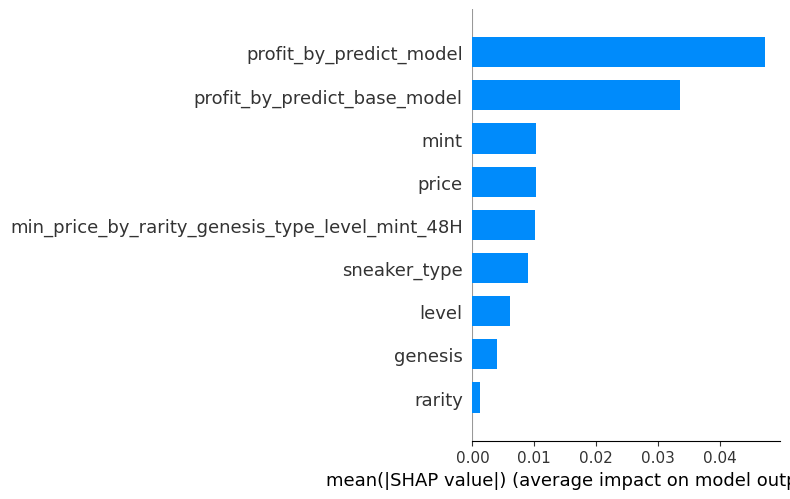

In [75]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_x)
shap.summary_plot(shap_values, features=X, feature_names=X.columns, plot_type='bar')

## TEST

In [76]:
model = CatBoostRegressor(
    depth=3,
    #learning_rate=0.01,
    #iterations=1000,
    loss_function='MAPE',
    random_seed=42
    )

# Fit model 
model.fit(X_train, y_train, cat_features=cat_features,)
#model.save_model(f'./models/sneaker_model_{VERSION}.model')

0:	learn: 0.1173825	total: 635us	remaining: 635ms
1:	learn: 0.1167158	total: 1.39ms	remaining: 696ms
2:	learn: 0.1157010	total: 1.84ms	remaining: 613ms
3:	learn: 0.1149119	total: 2.23ms	remaining: 556ms
4:	learn: 0.1143090	total: 2.63ms	remaining: 524ms
5:	learn: 0.1137039	total: 3.05ms	remaining: 506ms
6:	learn: 0.1127136	total: 3.4ms	remaining: 482ms
7:	learn: 0.1122129	total: 3.79ms	remaining: 470ms
8:	learn: 0.1116010	total: 4.2ms	remaining: 462ms
9:	learn: 0.1108340	total: 4.6ms	remaining: 455ms
10:	learn: 0.1103630	total: 4.99ms	remaining: 448ms
11:	learn: 0.1098143	total: 5.4ms	remaining: 444ms
12:	learn: 0.1092533	total: 5.76ms	remaining: 437ms
13:	learn: 0.1086908	total: 6.16ms	remaining: 434ms
14:	learn: 0.1082345	total: 6.52ms	remaining: 428ms
15:	learn: 0.1078328	total: 6.87ms	remaining: 422ms
16:	learn: 0.1075650	total: 7.28ms	remaining: 421ms
17:	learn: 0.1071398	total: 7.63ms	remaining: 416ms
18:	learn: 0.1065573	total: 7.95ms	remaining: 411ms
19:	learn: 0.1061412	total:

In [77]:
pred = model.predict(X_test)
pred = np.round(pred, 3)

score = score_regression_simple(y_test, pred,)
score

{'R2': 0.794, 'MAE': 0.063, 'MSE': 0.008, 'RMSE': 0.089, 'MAPE': 0.921}

In [78]:
submission = pd.DataFrame()
submission['profit'] = test_data.profit.copy().reset_index(drop=True)
submission['pred'] = pred

In [79]:
submission.profit.sum()

3.6959999999999997

In [80]:
submission

,profit,pred
0,0.0215,0.111
1,0.0780,0.047
2,0.1700,0.163
3,0.3200,0.360
4,0.4500,0.624
5,0.1015,0.068
6,0.0510,0.013
7,0.0590,0.039
8,0.1255,0.081
9,0.0615,0.023


In [81]:
submission[submission['pred'] > 0.05].profit.sum()

3.2284999999999995

In [82]:
pred = model.predict(X_test)
pred = np.round(pred, 2)

score = score_regression_simple(y_test, pred,)
score

iteritems is deprecated and will be removed in a future version. Use .items instead.


{'R2': 0.797, 'MAE': 0.063, 'MSE': 0.008, 'RMSE': 0.088, 'MAPE': 0.947}

## Fit full Model

In [83]:
X = data[features].copy().reset_index(drop=True)
y = data.target.copy().reset_index(drop=True)

model = CatBoostRegressor(
    depth=3,
    #learning_rate=0.01,
    #iterations=1000,
    loss_function='MAPE',
    random_seed=42
    )

# Fit model 
model.fit(X, y, cat_features=cat_features,)
model.save_model(f'./models/sneaker_profit_model_{VERSION}.model')

iteritems is deprecated and will be removed in a future version. Use .items instead.


0:	learn: 0.1175498	total: 507us	remaining: 507ms
1:	learn: 0.1166202	total: 970us	remaining: 484ms
2:	learn: 0.1159114	total: 1.37ms	remaining: 456ms
3:	learn: 0.1153102	total: 1.78ms	remaining: 444ms
4:	learn: 0.1145468	total: 2.17ms	remaining: 432ms
5:	learn: 0.1139561	total: 2.62ms	remaining: 434ms
6:	learn: 0.1129953	total: 3ms	remaining: 425ms
7:	learn: 0.1124555	total: 3.43ms	remaining: 426ms
8:	learn: 0.1118748	total: 3.82ms	remaining: 421ms
9:	learn: 0.1112420	total: 4.21ms	remaining: 417ms
10:	learn: 0.1105156	total: 4.58ms	remaining: 412ms
11:	learn: 0.1100100	total: 4.93ms	remaining: 406ms
12:	learn: 0.1095867	total: 5.29ms	remaining: 402ms
13:	learn: 0.1093196	total: 5.67ms	remaining: 399ms
14:	learn: 0.1089150	total: 5.98ms	remaining: 393ms
15:	learn: 0.1084823	total: 6.3ms	remaining: 388ms
16:	learn: 0.1079750	total: 6.66ms	remaining: 385ms
17:	learn: 0.1076248	total: 7.06ms	remaining: 385ms
18:	learn: 0.1069316	total: 7.4ms	remaining: 382ms
19:	learn: 0.1062811	total: 7

In [84]:
y

0      0.0770
1      0.0455
2      0.1740
3      0.3305
4      0.0685
        ...  
298    0.1075
299    0.0175
300    0.3635
301    0.0035
302   -0.0325
Name: target, Length: 303, dtype: float64

### Test

In [85]:
i=102

In [86]:
sneaker_dict = {}

features = data.columns

for feature in features:
    sneaker_dict[feature] = data.iloc[i][feature]

sneaker_dict['sum_activity_24H'] = sneaker_dict['buy_count_24H'] + sneaker_dict['sell_count_24H'] + sneaker_dict['cancel_count_24H']
sneaker_dict['sells_activity_24H'] = sneaker_dict['sell_count_24H'] / sneaker_dict['buy_count_24H']

sneaker_dict

{'timestamp': 1662991942,
 'mrk_id': 28113,
 'token_id': 45091,
 'event': 'buy',
 'wallet_from': '0xe6a733af0aeaadfb7fb23ed9751a86cffa3a9134',
 'wallet_to': '0x2b2f9ed8123c058c6f69cac2ab603ee5cb46d50c',
 'price': 0.87,
 'item_type': 'sneakers',
 'rarity': 'common',
 'sneaker_type': 'hiker',
 'level': 5,
 'base_performance': 6.7,
 'base_fortune': 9.0,
 'base_joy': 2.1,
 'base_durability': 6.6,
 'performance': 21.2,
 'fortune': 13.5,
 'joy': 3.1,
 'durability': 14.1,
 'mint': 1,
 'parent1': 34250.0,
 'parent2': 34779.0,
 'genesis': False,
 'parent1_sneaker_type': 'hiker',
 'parent2_sneaker_type': 'ranger',
 'price_bnb': 298.71675476,
 'price_azy': 0.0928018,
 'price_amt': 0.55517646,
 'wallet_from_buy_count': 0.0,
 'wallet_from_all_count': 5.0,
 'token_all_activity_3H': 1,
 'token_sell_activity_6H': 1,
 'buy_count_12H': 101,
 'buy_count_24H': 244,
 'buy_count_48H': 537.0,
 'sell_count_12H': 334.0,
 'sell_count_24H': 590,
 'sell_count_48H': 1192.0,
 'cancel_count_12H': 204.0,
 'cancel_cou

In [87]:
dq = data_quality_expected_range_dict['sneaker']['is_in']
for feature in dq.keys():
    if sneaker_dict[feature] is None:
        print(f'Nans in {feature}')

    if sneaker_dict[feature] not in dq[feature]:
        print(f'{feature} not in data_quality_expected_range_dict. get {sneaker_dict[feature]}')

dq = data_quality_expected_range_dict['sneaker']['min_max']
for feature in dq.keys():
    if sneaker_dict[feature] is None:
        print(f'Nans in {feature}')

    if sneaker_dict[feature] < dq[feature][0]:
        print(f'{feature} less then expected. get: {sneaker_dict[feature]} | expected: {dq[feature][0]}')

    if sneaker_dict[feature] > dq[feature][1]:
        print(f'{feature} more then expected. get: {sneaker_dict[feature]} | expected: {dq[feature][1]}')

In [88]:
pd.Series(sneaker_dict)[model.feature_names_]

rarity                                             common
sneaker_type                                        hiker
genesis                                             False
level                                                   5
mint                                                    1
min_price_by_rarity_genesis_type_level_mint_48H      0.93
price                                                0.87
profit_by_predict_model                            -0.024
profit_by_predict_base_model                       -0.091
dtype: object

In [89]:
MODEL_DIR = './models/'
MODEL_NAME = f'sneaker_profit_model_{VERSION}.model'

model = CatBoostRegressor()      # parameters not required.
model.load_model(MODEL_DIR+MODEL_NAME)

sample = pd.Series(sneaker_dict)
predict_price = model.predict(sample[model.feature_names_])
predict_price = np.round(predict_price, 3)
predict_price

0.001

In [90]:
data.iloc[i]['profit']

-0.005499999999999949

iteritems is deprecated and will be removed in a future version. Use .items instead.


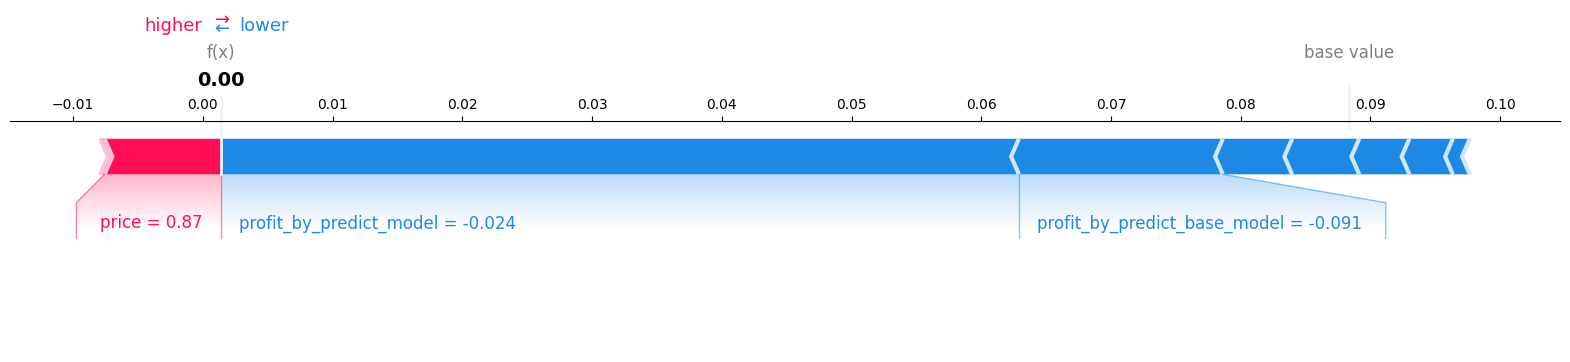

In [91]:
sample = pd.Series(sneaker_dict)
sample = pd.DataFrame(sample[model.feature_names_]).T
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(sample)
#shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], sample, show=True, matplotlib=True)